## Problem description

## Problem solution

## Functions for calculations

In [1]:
# Compute_wait_time: Generates trein schedules and passenger's arrival time,
# returns waiting time (min) for passenger to board the next trein.
# INPUT:
# num_trains      = (integer) total number of treins considered.
# intertime_short = (float) short interarrival time (min).
# intertime_long  = (float) long interarrival time (min).
# prob_short      = (float) probability train has SHORT interarrival time.
# OUTPUT:
# waittime_passenger = (float) waiting time to next trein (min).
Compute_wait_time = function(
  num_trains,
  intertime_short, 
  intertime_long,  
  prob_short){     
  
  # Probability trein has LONG interarrival time                        
  prob_long = 1 - prob_short 
  
  # Generate series of types of treins' interarrival times. 
  # Short and long interarrival times appear with 
  # probabilities prob_short and prob_long, respectively.
  isshort_intertime = sample(
    x = c(0,1), 
    size = num_trains,
    replace = TRUE,
    prob = c(prob_long, prob_short))
  
  # Generate trein's schedule
  intervals_short = isshort_intertime * intertime_short
  intervals_long = as.numeric(!isshort_intertime) * intertime_long
  intervals = intervals_short + intervals_long
  schedule = cumsum(intervals)
  
  # Generate (random) arrival time for passenger
  schedule_length = sum(intervals)
  arrivaltime_passenger = runif(n = 1, min = 0, max = schedule_length)
  
  # Find trein time interval corresponding to the moment 
  # when passenger arrives to platform
  i_passenger = findInterval(arrivaltime_passenger, schedule)
  
  # Compute waiting time for passenger
  waittime_passenger = schedule[i_passenger + 1] - arrivaltime_passenger
  
  return(waittime_passenger)
}

# Compute_mean_wait_time: Generates 'num_experiments' waiting times and 
# returns its mean.
# INPUT:
# num_experiments = (integer) Number of waiting times/experiments to generate. 
# num_trains      = (integer) total number of treins considered.
# intertime_short = (float) short interarrival time (min).
# intertime_long  = (float) long interarrival time (min).
# prob_short      = (float) probability train has SHORT interarrival time.
# OUTPUT:
# (float) mean waiting time to next trein (min).
Compute_mean_wait_time = function(
  num_experiments = 1000,
  num_trains = 20,
  intertime_short = 15, 
  intertime_long = 45,  
  prob_short = 0.5){
  
  # Compute waiting times
  wait_times = sapply(
    1:num_experiments, 
    function(i){
      Compute_wait_time(
        num_trains,
        intertime_short, 
        intertime_long,  
        prob_short)
  })
  
  # Return mean of waiting times
  return(mean(wait_times))
}

## Calculations

In [6]:
# Generate 100 approximations
ans = sapply(1:100, function(i){Compute_mean_wait_time()})
df = data.frame(experiment = 1:length(ans),
                wait_time = ans)

## Display results

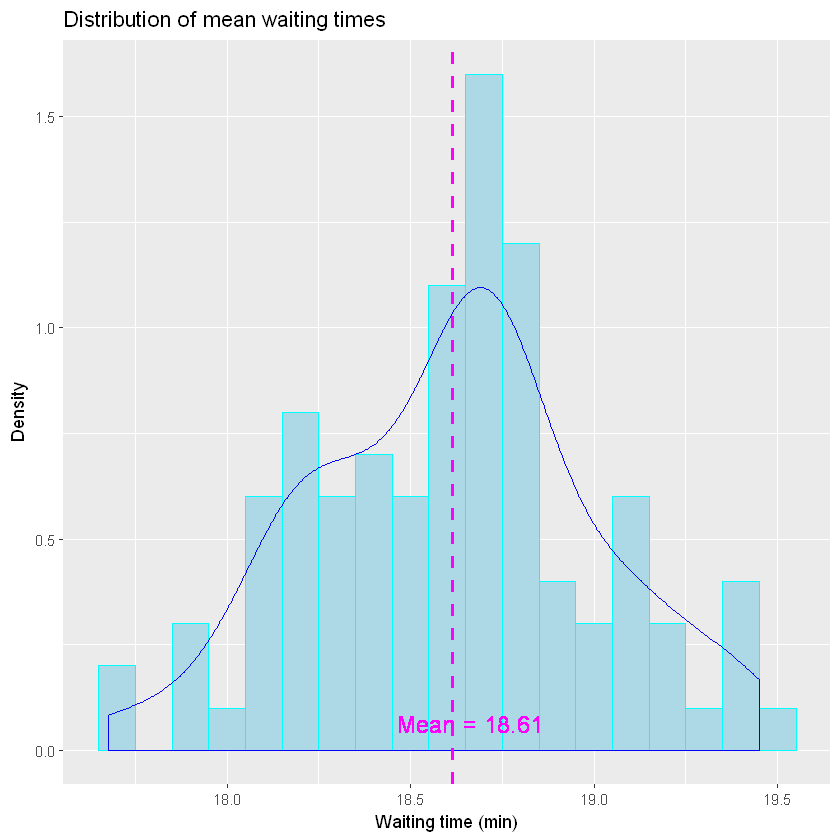

In [11]:
library(ggplot2)

ggplot(data = df, aes(wait_time)) + 
# Display histogram and density
  geom_histogram(aes(y = ..density..), 
                 col = 'cyan',
                 binwidth = 0.1,
                 fill = 'lightblue', 
                 alpha = 1) + 
  geom_density(col = 'blue') + 
  labs(title = 'Distribution of mean waiting times', 
       x = 'Waiting time (min)', 
       y = 'Density') + 
# Display mean vertical line
  geom_vline(aes(xintercept = mean(wait_time)),
             col = 'magenta', 
             size = 1,
             linetype = 'dashed') +
# Display mean value
  geom_text(aes(label = paste('Mean =', round(mean(wait_time), 2)),
                y = 0,
                x = mean(wait_time) + 0.05),
            vjust = -1,
            col = 'magenta',
            size = 5)
